Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build some models to predict the churn and use precision,recall, f1-score to measure performance of our model.

### We will go through project like this:
<h3 style='color:blue'>Handle imbalanced data in churn prediction.</h3>


1. Import Library
2. Load Data
3. EDA
4. Visulization
5. Preprocessing (Encoding , Scaling , Imputation)
6. Training the model
7. Evaluation

# 1. Import Libraries

In [100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

## 2. Load data and make dataframe

In [101]:
df = pd.read_csv("IT_customer_churn.csv")
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5394,Female,0,Yes,No,48,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),105.10,5083.55,No
1911,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),106.10,7657.4,No
1050,Male,1,No,No,12,No,No phone service,DSL,No,No,Yes,Yes,No,Yes,Month-to-month,Yes,Electronic check,43.65,526.95,Yes
5140,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,89.25,89.25,No
881,Male,1,No,No,26,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),19.30,504.2,No


In [39]:
columns = df.columns
columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [40]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [102]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


# 3. Do Some EDA

In [103]:
df.isnull().sum().sum()

0

In [104]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull().sum()

11

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with  this column**
**Lets convert it to numbers**

**Remove rows with space in TotalCharges**

In [105]:
df1 = df[df["TotalCharges"]!=" "]

In [106]:
df.shape

(7043, 20)

In [107]:
df1.shape

(7032, 20)

In [108]:
pd.to_numeric(df1.TotalCharges,errors='coerce').isnull().sum()

0

In [109]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

In [110]:
type(df1)

pandas.core.frame.DataFrame

In [111]:
df1.shape

(7032, 20)

In [112]:
df1.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


# 4. Let's do some  Visualization

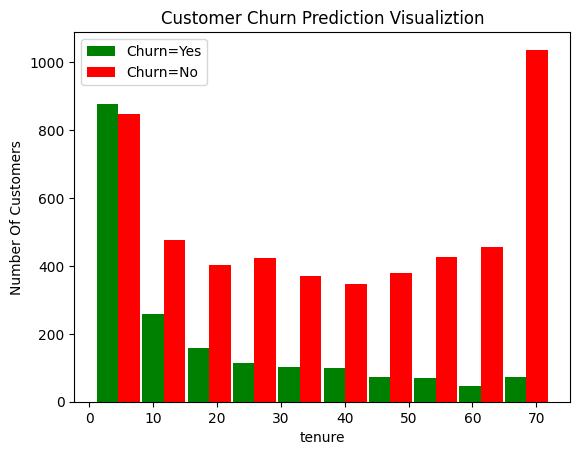

In [113]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()


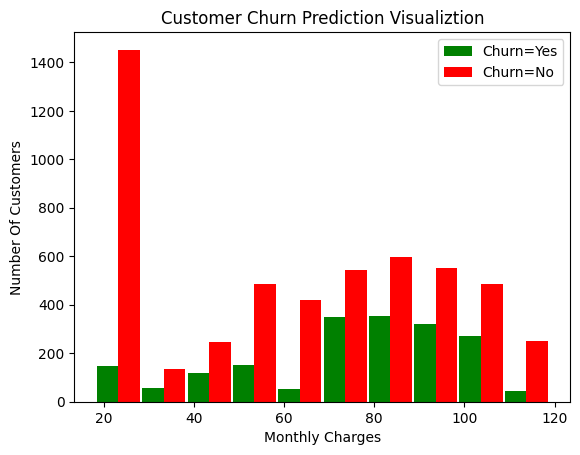

In [114]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

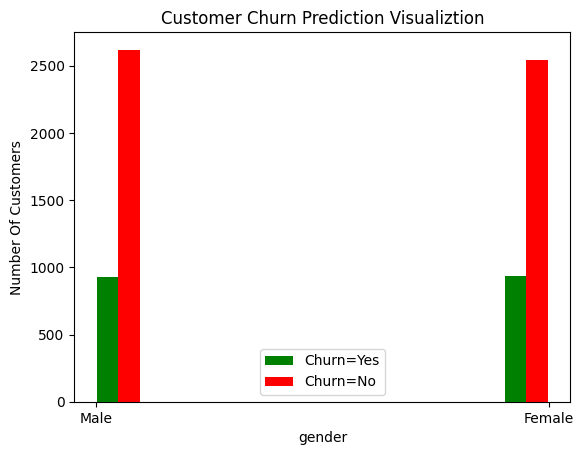

In [54]:
gender_churn_no = df1[df1.Churn=='No'].gender
gender_churn_yes = df1[df1.Churn=='Yes'].gender

plt.xlabel("gender")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([gender_churn_yes, gender_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

# 5. Data Preprocessing

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**

In [115]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [116]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [117]:
df1.replace("No internet service","No",inplace=True)
df1.replace("No phone service","No",inplace=True)

In [118]:
df1.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


**Convert Yes and No to 1 or 0**

In [119]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

In [120]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


**One hot encoding for categorical columns**

In [121]:
df1 = pd.get_dummies(df1,columns=['Contract','PaymentMethod','InternetService','gender'])


In [122]:
df1.head(2)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male
0,0,1,0,1,0,0,0,1,0,0,...,False,False,False,True,False,True,False,False,True,False
1,0,0,0,34,1,0,1,0,1,0,...,False,False,False,False,True,True,False,False,False,True


In [123]:
df1.dtypes

,0
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
OnlineSecurity,int64
OnlineBackup,int64
DeviceProtection,int64
TechSupport,int64


In [125]:
booleans = ['Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'gender_Female', 'gender_Male']

In [126]:
df1[booleans] = df1[booleans].astype('int64')
df1.sample(5)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male
6988,0,1,1,23,1,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0
3426,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
5332,0,0,0,47,1,0,1,1,0,1,...,0,0,0,0,1,1,0,0,1,0
6325,0,1,1,17,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,1,0
2194,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


**Scaling**

In [127]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

scaler = MinMaxScaler()
df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])


In [75]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
Streaming

## Train test split

In [128]:
X = df1.drop('Churn',axis='columns')
y = df1.Churn.astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [129]:
y_train.value_counts()

,count
Churn,
0.0,4130
1.0,1495


In [79]:
y.value_counts()

,count
Churn,
0.0,5163
1.0,1869


In [80]:
y_test.value_counts()

,count
Churn,
0.0,1033
1.0,374


In [81]:
X_train.shape

(5625, 27)

In [82]:
X_test.shape

(1407, 27)

In [83]:
X_train[:10]

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No,gender_Female,gender_Male
684,0,0,0,0.000000,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
2446,0,0,0,0.239437,1,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1680,0,1,1,0.774648,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2220,0,1,0,1.000000,1,0,1,1,0,1,...,1,1,0,0,0,1,0,0,0,1
2842,0,0,0,0.042254,0,0,1,0,1,1,...,0,0,0,0,1,1,0,0,1,0
5131,0,1,0,0.605634,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
4372,0,1,1,0.000000,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4687,0,1,0,0.295775,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
2385,0,0,1,0.028169,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,0
6773,1,1,0,0.507042,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [84]:
len(X_train.columns)

27

# Train the model
**Use logistic regression classifier**

In [130]:
def log_reg(X_train, y_train, X_test, y_test, weights):
    if weights==-1:
        model = LogisticRegression()
    else:
        model = LogisticRegression(class_weight={0:weights[0], 1:weights[1]})

    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print("Accuracy", acc, "\n")

    y_pred = model.predict(X_test)
    print("preds", y_pred[:5], "\n")

    cl_rep = classification_report(y_test,y_pred)
    print(cl_rep)

* weight means you are giving more importance to a particular class.

In [131]:
weights = -1 # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.8031272210376688 

preds [0. 0. 0. 0. 1.] 

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1033
         1.0       0.66      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407



In [132]:
weights = [1, 1.5] # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.7931769722814499 

preds [0. 0. 0. 0. 1.] 

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.86      1033
         1.0       0.60      0.68      0.64       374

    accuracy                           0.79      1407
   macro avg       0.74      0.76      0.75      1407
weighted avg       0.80      0.79      0.80      1407



* when we don't define class weights we get 0.66 precision and 0.54 recall.
* when we define class weights we get 0.60 precision and 0.68 recall.

# "Imbalanced dataset"

**SMOTE**

To install imbalanced-learn library use "pip install imbalanced-learn" command

In [133]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

,count
Churn,
0.0,5163
1.0,5163


In [134]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [135]:
# Number of classes in training Data
y_train.value_counts()

,count
Churn,
1.0,4130
0.0,4130


## Final results: Logistic Regression

In [136]:
weights = -1 # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.8005808325266215 

preds [1. 0. 1. 1. 0.] 

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79      1033
         1.0       0.78      0.83      0.81      1033

    accuracy                           0.80      2066
   macro avg       0.80      0.80      0.80      2066
weighted avg       0.80      0.80      0.80      2066



In [137]:
weights = [1, 1.5] # pass -1 to use Logistics Regression without weights
log_reg(X_train, y_train, X_test, y_test, weights)

Accuracy 0.8010648596321394 

preds [1. 0. 1. 1. 0.] 

              precision    recall  f1-score   support

         0.0       0.87      0.70      0.78      1033
         1.0       0.75      0.90      0.82      1033

    accuracy                           0.80      2066
   macro avg       0.81      0.80      0.80      2066
weighted avg       0.81      0.80      0.80      2066



# **Xgboost**

In [156]:
def X_gboost(X_train, y_train, X_test, y_test, weights):
    if weights==-1:
        model = XGBClassifier()
    else:
        model = XGBClassifier(class_weight={0:weights[0], 1:weights[1]})

    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print("Accuracy", acc, "\n")

    y_pred = model.predict(X_test)
    print("preds", y_pred[:5], "\n")

    cl_rep = classification_report(y_test,y_pred)
    print(cl_rep)

In [157]:
weights = -1 # pass -1 to use Logistics Regression without weights
X_gboost(X_train, y_train, X_test, y_test, weights)

Accuracy 0.8146176185866408 

preds [1 0 1 1 0] 

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      1033
         1.0       0.80      0.84      0.82      1033

    accuracy                           0.81      2066
   macro avg       0.82      0.81      0.81      2066
weighted avg       0.82      0.81      0.81      2066



In [158]:
weights = [1, 1.5]
X_gboost(X_train, y_train, X_test, y_test, weights)

Accuracy 0.8146176185866408 

preds [1 0 1 1 0] 

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      1033
         1.0       0.80      0.84      0.82      1033

    accuracy                           0.81      2066
   macro avg       0.82      0.81      0.81      2066
weighted avg       0.82      0.81      0.81      2066

